In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
"""
import os
from collections import defaultdict
from glob import glob
import netCDF4
from netCDF4 import Dataset
from satpy import Scene
from satpy import available_readers
from satpy import available_writers
from satpy import resample
import math
import numpy as np
import itertools as it
import functools as ft
from pathlib import Path
import sqlite3
import time
from collections import defaultdict
from satpy import Scene
from pyresample.geometry import SwathDefinition
import sys
import xarray

In [39]:
#http://127.0.0.1:8898/edit/GOESABICOLOCATION_TEST/GOES/OR_ABI-L1b-RadF-M6C15_G17_s20201560830320_e20201560839392_c20201560839439.nc
filenames = glob("GOES/OR*s20201560830*")
#filenames = glob("GOES/OR*")
Vnames = glob("VIIRS/G*0848*.h5")
SMnames = glob("VIIRS/G*SMR*848*.nc")
print(filenames)
print(Vnames)
global_scene = Scene(reader="abi_l1b", filenames=filenames)
viirs_scene = Scene(reader='viirs_sdr', filenames =Vnames)
#SM_scence = Scene(reader = 'satpy_cf_nc', filenames =SMnames)

#'#{platform_name}-{sensor}-{start_time:%Y%m%d%H%M%S}-{end_time:%Y%m%d%H%M%S}.nc'

['GOES/OR_ABI-L1b-RadF-M6C15_G17_s20201560830320_e20201560839392_c20201560839439.nc', 'GOES/OR_ABI-L1b-RadF-M6C13_G17_s20201560830320_e20201560839398_c20201560839447.nc', 'GOES/OR_ABI-L1b-RadF-M6C07_G17_s20201560830320_e20201560839398_c20201560839443.nc', 'GOES/OR_ABI-L1b-RadF-M6C11_G17_s20201560830320_e20201560839386_c20201560839450.nc']
['VIIRS/GDNBO-SVDNB_npp_d20200605_t0848167_e0853571_b44591_c20210825214120071069_nobc_ops.h5', 'VIIRS/GMODO-SVM01-SVM02-SVM03-SVM04-SVM05-SVM06-SVM07-SVM08-SVM09-SVM10-SVM11-SVM12-SVM13-SVM14-SVM15-SVM16_npp_d20200605_t0848167_e0853571_b44591_c20210825214130028936_nobc_ops.h5']


In [3]:
global_scene.available_dataset_names()

['C07', 'C11', 'C13', 'C15']

In [40]:
viirs_scene.available_dataset_names()

['DNB',
 'M01',
 'M02',
 'M03',
 'M04',
 'M05',
 'M06',
 'M07',
 'M08',
 'M09',
 'M10',
 'M11',
 'M12',
 'M13',
 'M14',
 'M15',
 'M16',
 'dnb_latitude',
 'dnb_longitude',
 'dnb_lunar_azimuth_angle',
 'dnb_lunar_zenith_angle',
 'dnb_moon_illumination_fraction',
 'dnb_satellite_azimuth_angle',
 'dnb_satellite_zenith_angle',
 'dnb_solar_azimuth_angle',
 'dnb_solar_zenith_angle',
 'm_latitude',
 'm_longitude',
 'satellite_azimuth_angle',
 'satellite_zenith_angle',
 'solar_azimuth_angle',
 'solar_zenith_angle']

In [36]:
global_scene.load(["C07", "C11", "C13", 'C15'])
global_scene.keys()

[DataID(name='C07', wavelength=WavelengthRange(min=3.8, central=3.9, max=4.0, unit='µm'), resolution=2000, calibration=<calibration.brightness_temperature>, modifiers=()),
 DataID(name='C11', wavelength=WavelengthRange(min=8.3, central=8.5, max=8.7, unit='µm'), resolution=2000, calibration=<calibration.brightness_temperature>, modifiers=()),
 DataID(name='C13', wavelength=WavelengthRange(min=10.1, central=10.35, max=10.6, unit='µm'), resolution=2000, calibration=<calibration.brightness_temperature>, modifiers=()),
 DataID(name='C15', wavelength=WavelengthRange(min=11.8, central=12.3, max=12.8, unit='µm'), resolution=2000, calibration=<calibration.brightness_temperature>, modifiers=())]

In [41]:
viirs_scene.load(["DNB", "M13", "M14", "M15", "M16", 'dnb_latitude', 'dnb_longitude', 'm_latitude', 'm_longitude'])
viirs_scene.keys()

Failed to load coordinates for 'DataID(name='dnb_longitude', resolution=743, modifiers=())'
Failed to load coordinates for 'DataID(name='m_longitude', resolution=742, modifiers=())'
Failed to load coordinates for 'DataID(name='dnb_latitude', resolution=743, modifiers=())'
Failed to load coordinates for 'DataID(name='m_latitude', resolution=742, modifiers=())'


[DataID(name='DNB', wavelength=WavelengthRange(min=0.5, central=0.7, max=0.9, unit='µm'), resolution=743, calibration=<calibration.radiance>, modifiers=()),
 DataID(name='M13', wavelength=WavelengthRange(min=3.973, central=4.05, max=4.128, unit='µm'), resolution=742, calibration=<calibration.brightness_temperature>, modifiers=()),
 DataID(name='M14', wavelength=WavelengthRange(min=8.4, central=8.55, max=8.7, unit='µm'), resolution=742, calibration=<calibration.brightness_temperature>, modifiers=()),
 DataID(name='M15', wavelength=WavelengthRange(min=10.263, central=10.763, max=11.263, unit='µm'), resolution=742, calibration=<calibration.brightness_temperature>, modifiers=()),
 DataID(name='M16', wavelength=WavelengthRange(min=11.538, central=12.013, max=12.489, unit='µm'), resolution=742, calibration=<calibration.brightness_temperature>, modifiers=()),
 DataID(name='dnb_latitude', resolution=743, modifiers=()),
 DataID(name='dnb_longitude', resolution=743, modifiers=()),
 DataID(name='

In [53]:
#print/confirming shape of the original files before data manipulation 
print('these are the start shapes of data files')
#print('C07',global_scene[C07].shape())
print('C11', global_scene['C11'].shape)
#print('C13', global_scene[C13].shape)
#print('C15', global_scene[C15].shape)
print('M16', viirs_scene['M16'].shape)
print('DNB', viirs_scene['DNB'].shape)
print('DNB lat', viirs_scene['dnb_latitude'].shape)
print('DNB long', viirs_scene['dnb_longitude'].shape)
print(' Mband lat', viirs_scene['m_latitude'].shape)
print(' Mband long', viirs_scene['m_longitude'].shape)
print('this is the end of initial shape confirmation')

    #now resample the Mband to the DNB with a new "Scene" role
    #print('starting resampling of Mbands to DNB')
    #Mband_resample_scn=original_scn.resample(original_scn['DNB'].attrs['area'], resampler='nearest')
    #Mband_resample_scn=resample.resample(
    
    
    


these are the start shapes of data files


KeyError: "No dataset matching 'DataQuery(name='C11')' found"

In [7]:
channels = ['C07','C11','C13','C15']#,'M16','DNB']

for c in channels:
       # original_scn.save_dataset(c, f'{spath2}ORIGINAL_{c}_{starttime}.png', writer='simple_image')
         #original_scn.save_dataset(c, spath2 + 'ORIGINAL_' + c + "_" + starttime + '.png', writer='simple_image') #engine='netcdf4')
    global_scene.save_dataset(c, 'ORIGINAL_' + c + "_s20201560830320.nc", writer='cf')         
       # Mband_resample_scn.save_dataset(c, spath2 + 'COLOCATED_' + c + "_" + starttime + '.png', writer='simple_image') #engine='netcdf4')
       # Mband_resample_scn.save_dataset(c, spath2 + 'COLOCATED_' +  c + "_" + starttime + '.nc', writer='cf')  

No time dimension in datasets, skipping time bounds creation.
/usr/local/anaconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))
No time dimension in datasets, skipping time bounds creation.
/usr/local/anaconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))
No time dimension in datasets, skipping time bounds creation.
No time dimension in datasets, skipping time bounds creation.


In [55]:

from netCDF4 import Dataset as NetCDFFile 
import matplotlib.pyplot as plt
import numpy as np
nc = NetCDFFile('ORIGINAL_C07_s20201560830320.nc')
ncRAW = NetCDFFile("GOES/OR_ABI-L1b-RadF-M6C07_G17_s20201560830320_e20201560839398_c20201560839443.nc")

In [57]:
ncRAW.variables

{'Rad': <class 'netCDF4._netCDF4.Variable'>
 int16 Rad(y, x)
     _FillValue: 16383
     long_name: ABI L1b Radiances
     standard_name: toa_outgoing_radiance_per_unit_wavenumber
     _Unsigned: true
     sensor_band_bit_depth: 14
     valid_range: [    0 16382]
     scale_factor: 0.001564351
     add_offset: -0.0376
     units: mW m-2 sr-1 (cm-1)-1
     resolution: y: 0.000056 rad x: 0.000056 rad
     coordinates: band_id band_wavelength t y x
     grid_mapping: goes_imager_projection
     cell_methods: t: point area: point
     ancillary_variables: DQF
 unlimited dimensions: 
 current shape = (5424, 5424)
 filling on,
 'DQF': <class 'netCDF4._netCDF4.Variable'>
 int8 DQF(y, x)
     _FillValue: -1
     long_name: ABI L1b Radiances data quality flags
     standard_name: status_flag
     _Unsigned: true
     valid_range: [0 4]
     units: 1
     coordinates: band_id band_wavelength t y x
     grid_mapping: goes_imager_projection
     cell_methods: t: point area: point
     flag_values:

In [58]:
lat = nc.variables['latitude'][:]
lon = nc.variables['longitude'][:]
C07 = nc.variables['C07'][:]
RAWC07 =ncRAW.variables['Rad'][:]


<ipython-input-58-6a3c591f8492>:4: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  RAWC07 =ncRAW.variables['Rad'][:]


In [60]:
RAWC07.max(),RAWC07.min()

(25.5896, -0.0031842776)

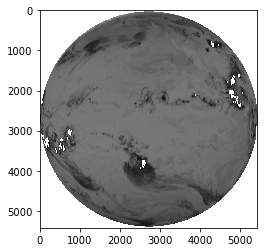

In [17]:
imgplot = plt.imshow(C07, cmap = 'gray')#, vmin=0, vmax=100)

In [3]:
from netCDF4 import Dataset
C15 = Dataset("GOES/OR_ABI-L1b-RadF-M6C15_G17_s20201560830320_e20201560839392_c20201560839439.nc")
C13 = Dataset("GOES/OR_ABI-L1b-RadF-M6C13_G17_s20201560830320_e20201560839398_c20201560839447.nc")
C11 = Dataset("GOES/OR_ABI-L1b-RadF-M6C11_G17_s20201560830320_e20201560839386_c20201560839450.nc")
C07 = Dataset("GOES/OR_ABI-L1b-RadF-M6C07_G17_s20201560830320_e20201560839398_c20201560839443.nc")

In [5]:
single=np.stack((C15, C13, C11, C07),axis=-1) #combines
print(single.shape)

(4,)


In [ ]:
filleddic = {}

filleddic['FC15'] = C15['C15'][:].filled(-9999)
filleddic['FC13'] = C13['C13'][:].filled(-9999)
filleddic['FC11'] = C11['C11'][:].filled(-9999)
filleddic['FC07'] = C07['C07'][:].filled(-9999)
